# Getting Started with `bw_timex`

Here's a rundown of the steps involved in a `TimexLCA`:

<div style="display: flex; justify-content: center; background-color: white; border-radius: 15px; padding: 10px; width: 45%; margin: auto;">
  <img src="data/method.svg" style="border-radius: 15px; width: 100%;">
</div>

Let's walk through steps 1-4 considering a very simple dummy system. This is our "static system model":

```mermaid
flowchart LR
subgraph background[<i>background</i>]
    B(Process B):::bg
end

subgraph foreground[<i>foreground</i>]
    A(Process A):::fg
end

subgraph biosphere[<i>biosphere</i>]
    CO2(CO2):::bio
end

B-->|"3 kg"|A
A-.->|"5 kg"|CO2
B-.->|"11 kg"|CO2

classDef fg color:#222832, fill:#3fb1c5, stroke:none;
classDef bg color:#222832, fill:#3fb1c5, stroke:none;
classDef bio color:#222832, fill:#9c5ffd, stroke:none;
style background fill:none, stroke:none;
style foreground fill:none, stroke:none;
style biosphere fill:none, stroke:none;
```

Setting this up in brightway:

In [25]:
import bw2data as bd

bd.projects.set_current("getting_started_with_timex")

bd.Database("biosphere").write(
    {
        ("biosphere", "CO2"): {
            "type": "emission",
            "name": "CO2",
        },
    }
)

bd.Database("background_2020").write(
    {
        ("background_2020", "B"): {
            "name": "B",
            "location": "somewhere",
            "reference product": "B",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("background_2020", "B"),
                },
                {
                    "amount": 11,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                },
            ],
        },
    }
)

bd.Database("foreground").write(
    {
        ("foreground", "A"): {
            "name": "A",
            "location": "somewhere",
            "reference product": "A",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("foreground", "A"),
                },
                {
                    "amount": 3,
                    "type": "technosphere",
                    "input": ("background_2020", "B"),
                },
                {
                    "amount": 5,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                }
            ],
        },
    }
)

bd.Method(("our", "method")).write(
    [
        (("biosphere", "CO2"), 1),
    ]
)

100%|██████████| 1/1 [00:00<00:00, 12985.46it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 8004.40it/s]

Vacuuming database 


## Step 1 - Adding temporal information

### Temporal distributions - *"distributing exchanges over time"*

Temporal information is carried by [`TemporalDistribution`](https://docs.brightway.dev/projects/bw-temporalis/en/stable/content/api/bw_temporalis/temporal_distribution/index.html#bw_temporalis.temporal_distribution.TemporalDistribution) objects, originally introduced by [`bw_temporalis`](https://github.com/brightway-lca/bw_temporalis). 

> A `TemporalDistribution` tells you what share of an exchange happens at what point in time. 




Making up some temporal information:

```mermaid
flowchart LR
subgraph background[" "]
    B_2020(Process B):::bg
end

subgraph foreground[" "]
    A(Process A):::fg
end

subgraph biosphere[" "]
    CO2(CO2):::b
end

B_2020-->|"amounts: [30%,50%,20%] * 3 kg\n dates:[-2,0,+4]" years|A
A-.->|"amounts: [60%, 40%] * 5 kg\n dates: [0,+1]" years|CO2
B_2020-.->|"amounts: [100%] * 11 kg\n dates:[0]" years|CO2

classDef bg color:#222832, fill:#3fb1c5, stroke:none;
classDef fg color:#222832, fill:#3fb1c5, stroke:none;
classDef b color:#222832, fill:#9c5ffd, stroke:none;
style foreground fill:none, stroke:none;
style background fill:none, stroke:none;
style biosphere fill:none, stroke:none;

```

In [26]:
import numpy as np
from bw_temporalis import TemporalDistribution

td_b_to_a = TemporalDistribution(
    date=np.array([-2, 0, 4], dtype="timedelta64[Y]"),
    amount=np.array([0.3, 0.5, 0.2]),
)

Adding a `TemporalDistribution` to an exchange is as easy as:
```python
exchange_object["temporal_distribution"] = TemporalDistribution 
```

However, we don't have the `exchange_object` at hand here - but we can use the utility function `add_temporal_distribution_to_exchange()`:

In [27]:
from bw_timex.utils import add_temporal_distribution_to_exchange

add_temporal_distribution_to_exchange(
    temporal_distribution=td_b_to_a, 
    input_code="B", 
    input_database="background_2020",
    output_code="A",
    output_database="foreground"
)

The same for the exchange between A and CO2:

In [28]:
td_a_to_co2 = TemporalDistribution(
    date=np.array([0, 1], dtype="timedelta64[Y]"),
    amount=np.array([0.6, 0.4]),
)

# We actually only have to define enough fields to uniquely identify the exchange here
add_temporal_distribution_to_exchange(
    temporal_distribution=td_a_to_co2, 
    input_code="CO2", 
    output_code="A"
)

### Time-specific process data

We need to include the information how our processes change over time. 

Let's say process B reduces its emissions from 11kg CO2 in 2020 to 7kg CO2 in 2030:

```mermaid
flowchart LR
subgraph background[" "]
    B_2020(Process B \n 2020):::bg
    B_2030(Process B \n 2030):::bg
end

subgraph foreground[" "]
    A(Process A):::fg
end

subgraph biosphere[" "]
    CO2(CO2):::b
end

B_2020-->|"amounts: [30%,50%,20%] * 3 kg\n dates:[-2,0,+4]" years|A
A-.->|"amounts: [60%, 40%] * 5 kg\n dates: [0,+1]" years|CO2
B_2020-.->|"amounts: [100%] * <span style='color:#9c5ffd'><b>11 kg</b></span>\n dates:[0]" years|CO2
B_2030-.->|"amounts: [100%] * <span style='color:#9c5ffd'><b>7 kg</b></span>\n dates:[0]" years|CO2

classDef bg color:#222832, fill:#3fb1c5, stroke:none;
classDef fg color:#222832, fill:#3fb1c5, stroke:none;
classDef b color:#222832, fill:#9c5ffd, stroke:none;
style foreground fill:none, stroke:none;
style background fill:none, stroke:none;
style biosphere fill:none, stroke:none;

```

> **Note:** It does not matter where your prospective data is coming from - you can also use [premise](https://premise.readthedocs.io/en/latest/introduction.html).


In [29]:
bd.Database("background_2030").write(
    {
        ("background_2030", "B"): {
            "name": "B",
            "location": "somewhere",
            "reference product": "B",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("background_2030", "B"),
                },
                {
                    "amount": 7,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                },
            ],
        },
    }
)

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 14665.40it/s]

Vacuuming database 


To hand this information to `bw_timex`, we define a `database_date_dict`:

In [30]:
from datetime import datetime

database_date_dict = {
    "background_2020": datetime.strptime("2020", "%Y"),
    "background_2030": datetime.strptime("2030", "%Y"),
    "foreground": "dynamic", # no specific point in time, but should be "distributed over time"
}

## Step 2 - Building the process timeline 

Now we can instantiate a `TimexLCA` object - similarly to a normal Brightway LCA object, but with the additional argument of our `database_date_dict`.

Let's demand process A to run once:

In [31]:
from bw_timex import TimexLCA

tlca = TimexLCA(
    demand={("foreground", "A"): 1},
    method=("our", "method"),
    database_date_dict=database_date_dict,
)

If not specified otherwise, `bw_timex` assumes the demand occurs at `datetime.datetime.now()`, translating to the year 2024 at the time of writing this.

Building the process timeline is very simple now:

In [32]:
tlca.build_timeline()

Starting graph traversal
Calculation count: 1


/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timex_lca.py:212: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(


,date_producer,producer_name,date_consumer,consumer_name,amount,interpolation_weights
0,2022-01-01,B,2024-01-01,A,0.9,"{'background_2020': 0.7998905009581166, 'backg..."
1,2024-01-01,B,2024-01-01,A,1.5,"{'background_2020': 0.6000547495209416, 'backg..."
2,2024-01-01,A,2024-01-01,-1,1.0,None
3,2028-01-01,B,2024-01-01,A,0.6,"{'background_2020': 0.20010949904188335, 'back..."


The timeline tells us which exchange happens at what time. Also, we see the "interpolation_weights", already giving a hint on how the processes will be re-linked in the next step. 

For the first row of the timeline, the interpolation weights are:

In [33]:
tlca.timeline.interpolation_weights[0]

{'background_2020': 0.7998905009581166, 'background_2030': 0.20010949904188338}

## Step 3 - Calculating the time-explicit LCI

Calculating the time-explicit LCI from the timeline is very simple, at least from the user perspective:


In [34]:
tlca.lci()

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)


Under the hood, we re-build the technosphere and biosphere matrices, adding new rows and columns to carry the extra temporal information. More on that in the [Theory Section](https://docs.brightway.dev/projects/bw-timex/en/latest/content/theory.html#modifying-the-matrices) of our docs.

## Step 4 - Impact assessment

To characterize the calculated inventory, we have two options: Static and dynamic life cycle impact assessment (LCIA).

### Static LCIA
If we don't care about the timing of the emissions, we can do static LCIA, using static characterization factors. 

To characterize the inventory with the impact assessment method that we initially chose when creating our `TimexLCA`, we can simply call:

In [35]:
tlca.static_lcia()

and investigate the resulting score like this:

In [36]:
tlca.static_score

32.96019709827539

### Dynamic LCIA

The inventory calculated by a `TimexLCA` retains temporal information. We don't only know what substance is emitted by what process, but also at what time. 

Therefore, we can apply advanced dynamic characterization functions, rather than just applying characterization factors. You can either:
- define your own, custom dynamic characterization functions or 
- use existing ones, e.g., from the package [`dynamic_characterization`](https://dynamic-characterization.readthedocs.io/en/latest/). 

To keep it simple here, we'll do the latter. 

Let's import a dynamic characterization function and define which biosphere flow it applies to:

In [46]:
from dynamic_characterization.timex import characterize_co2
emission_id = bd.get_activity(("biosphere", "CO2")).id

characterization_function_dict = {
    emission_id: characterize_co2,
}

> **Note:** If you're working with biosphere3 flows, you don't have to specify this - the `dynamic_characterization` package takes care of the mapping automatically.

For a start, let's use the "standard" metric Global Warming Potential over a time horizon of 100 years:

In [38]:
tlca.dynamic_lcia(
    metric="GWP",
    time_horizon=100,
    characterization_function_dict=characterization_function_dict,
)

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/dynamic_characterization/dynamic_characterization.py:262: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(


,date,amount,flow,activity
0,2022-01-01 00:00:00,9.179606,395,399
1,2024-01-01 00:00:00,14.100328,395,400
2,2024-01-01 00:00:00,3.000000,395,401
3,2024-12-31 05:49:12,2.000000,395,401
4,2028-01-01 00:00:00,4.680263,395,402


We can plot the characterized inventory with:

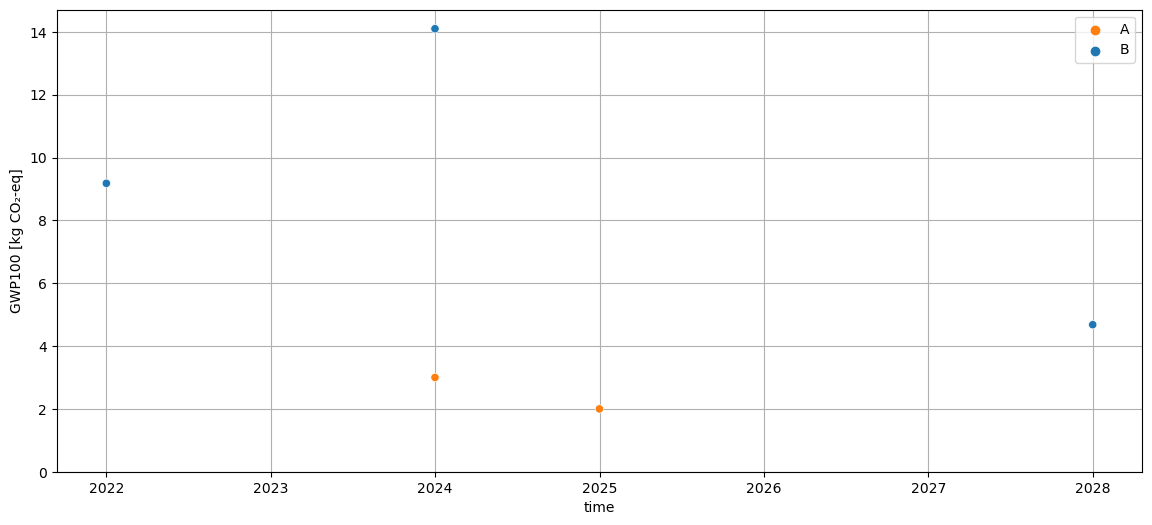

In [40]:
tlca.plot_dynamic_characterized_inventory()

We can go one step further though. Instead of GWP, we can directly assess the radiative forcing (which gets aggregated and normalized in GWP):

In [41]:
tlca.dynamic_lcia(
    metric="radiative_forcing",
    time_horizon=100,
    characterization_function_dict=characterization_function_dict,
)

,date,amount,flow,activity
0,2023-01-01 05:49:12,1.512067e-14,395,399
1,2024-01-01 11:38:24,1.419411e-14,395,399
2,2024-12-31 05:49:12,2.322610e-14,395,400
3,2024-12-31 05:49:12,4.941608e-15,395,401
4,2024-12-31 17:27:36,1.343660e-14,395,399
...,...,...,...,...
490,2124-01-01 06:00:00,1.400972e-15,395,401
491,2124-01-01 06:43:12,3.302104e-15,395,402
492,2124-12-31 12:32:24,3.294094e-15,395,402
493,2125-12-31 18:21:36,3.286213e-15,395,402


...and plot it:

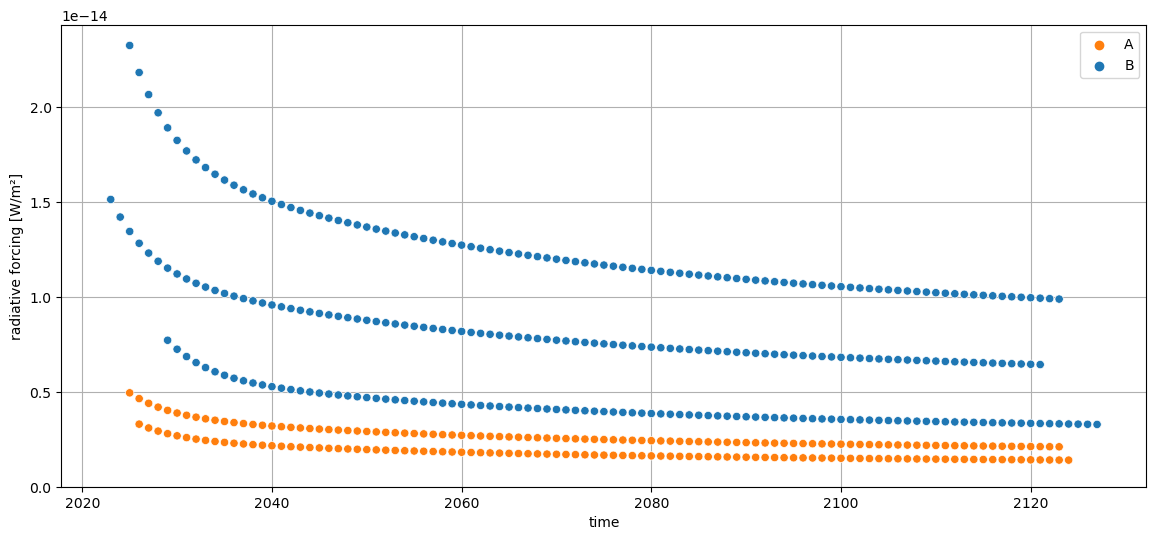

In [44]:
tlca.plot_dynamic_characterized_inventory()

We essentially see the decay curves of our individual emissions. 

In this sense, the overall impact is represented by the cumulative sum:

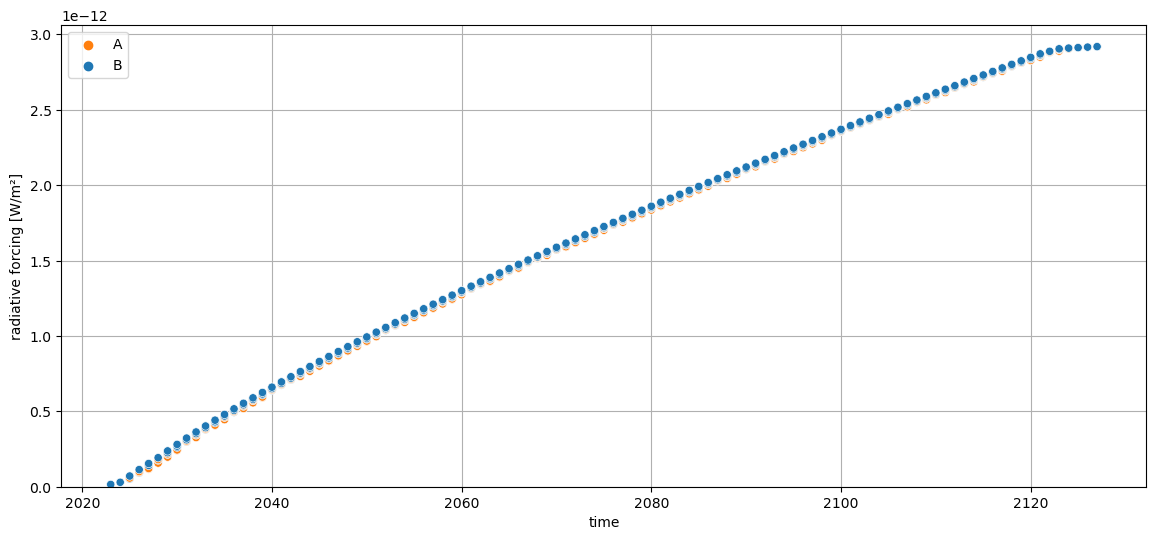

In [45]:
tlca.plot_dynamic_characterized_inventory(cumsum=True)

For most of the functions we used here, there are numerous optional arguments and settings you can tweak. We explore some of them in our other [Examples](https://docs.brightway.dev/projects/bw-timex/en/latest/content/examples/index.html), but when in doubt: Our code is pretty well documented, see our [API Reference](https://docs.brightway.dev/projects/bw-timex/en/latest/content/api/index.html) - so please browse through that as needed ☀️